분류 모델 결과를 자동으로 라우팅

In [ ]:
# 라우팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 세팅_0.1
목적: 입력된 CT 영상에서 병변(출혈)을 픽셀 단위로 분할
=> 픽셀에 병변이다 아니다의 정보값을 넣음

- 모델 ResUNet50 (2D) <br>
: 2022 논문 참고하여 선택

- 입력 512×512 grayscale CT 슬라이스

- 출력 Binary mask (출혈 영역)<br>
: 출혈 vs 비출혈이 명확한 binary 문제

- Loss Dice + BCE (또는 Focal)<br>
: Dice + BCE 조합: pixel-level + region-level 모두 고려<br>
Focal(출혈 영역이 아주 작을 때 고려) => 최종 focal

- Optimizer Adam <br>
: 의료 영상에서 거의 디폴트

- Scheduler ReduceLROnPlateau<br>
: validation loss가 plateau에 들어가면 자동으로 lr 줄여줌<br>
특히 의료처럼 overfitting 빨리 오는 경우 유리

- 평가 지표 dice, iou, sensitivity, specificity, precision, f1_score


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

In [3]:
# === 설정 블럭 (한 곳에서 조정 가능) ===
CONFIG = {
    "image_dir": "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/data/hemorrhage/images",
    "mask_dir": "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/data/hemorrhage/masks",
    "batch_size": 8,
    "num_epochs": 40,
    "learning_rate": 1e-4,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [4]:
# 모델 스켈레톤
# --- Residual Block (optional) ---
# 두 번의 Conv + BN + ReLU로 구성된 블록으로, U-Net의 기본 단위입니다.
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# --- Upconvolution block ---
# 업샘플링(ConvTranspose2d) 후 skip connection을 통해 encoder feature와 결합하고 ConvBlock 적용
class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)

        # spatial size가 다르면 강제로 맞춰주기 (interpolation)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)

        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# --- ResUNet50 Model ---
def build_model(n_classes=1):
    """
    모델을 생성하는 함수 (외부에서 쉽게 재사용하기 위해)
    - n_classes: 출력 채널 수 (binary segmentation은 1)
    """
    return ResUNet50(n_classes)

# ResNet50을 encoder로 사용하고 U-Net 구조로 decoder를 구성한 세그멘테이션 모델
class ResUNet50(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        base_model = models.resnet50(pretrained=True)

        base_model.conv1 = nn.Conv2d(
        in_channels=1,
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3,
        bias=False
        )

        # ResNet 초기 conv block: conv1 + BN + ReLU + MaxPool
        self.inconv = nn.Sequential(
            base_model.conv1,
            base_model.bn1,
            base_model.relu,
            base_model.maxpool
        )

        # ResNet encoder block 계층
        self.encoder1 = base_model.layer1  # 256
        self.encoder2 = base_model.layer2  # 512
        self.encoder3 = base_model.layer3  # 1024
        self.encoder4 = base_model.layer4  # 2048

        # bottleneck에 해당하는 중간 블록
        self.center = ConvBlock(2048, 1024)

        # Decoder 부분: 업샘플링 후 skip 연결
        self.up4 = UpBlock(1024, 1024, 512)
        self.up3 = UpBlock(512, 512, 256)
        self.up2 = UpBlock(256, 256, 128)
        self.up1 = UpBlock(128, 64, 64)

        # 최종 출력 계층: 채널 수 = 클래스 수 (binary일 경우 1) =>  binary mask (1 = 병변, 0 = 정상)
        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x0 = self.inconv(x)      # 64
        x1 = self.encoder1(x0)   # 256
        x2 = self.encoder2(x1)   # 512
        x3 = self.encoder3(x2)   # 1024
        x4 = self.encoder4(x3)   # 2048

        center = self.center(x4)

        d4 = self.up4(center, x3)
        d3 = self.up3(d4, x2)
        d2 = self.up2(d3, x1)
        d1 = self.up1(d2, x0)

        out = self.final(d1)
        out = F.interpolate(out, size=(512, 512), mode='bilinear', align_corners=False)
        return out

# out = self.final(d1)
# => shape(B, 1, H, W) 배치단위 binary mask
# 각 픽셀의 값은 병변(출혈)일 확률에 해당 (픽셀: 0.92 => 출혈일 확률 92%)
# 학습은 sigmoid(out)에 대한 Binary Cross Entropy + Dice loss
# **BCE 선택 이유: 각 픽셀의 확률(0~1)을 정답(0 또는 1)과 비교(이진)하는 것이기 때문
# 추론은 out > 0.5 같은 threshold로 마스크를 만들어서 이 픽셀은 출혈(1) or not(0)을 판별

In [5]:
# --- 학습 루프 ---
# 모델을 train 모드로 전환해 학습(역전파)
# train set 적용
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [6]:
# --- 검증 루프 ---
# 모델을 평가 모드로 설정하고 loss만 계산(역전파 X)
# 학습 후 모델의 성능을 평가할 때 사용
# val set 사용
def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            loss = criterion(preds, masks)
            val_loss += loss.item()
    return val_loss / len(loader)

In [7]:
# --- Dice Loss ---
# 마스크 전체의 overlap 정도를 계산하여 구조적 유사도를 반영합니다.
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

# --- 복합 손실 함수 (BCE + Dice) ---
# 픽셀 단위 예측 정확도(BCE)와 전체 마스크 유사도(Dice)를 함께 고려
def combined_loss(preds, targets):
    bce = F.binary_cross_entropy_with_logits(preds, targets)
    dice = DiceLoss()(preds, targets)
    return bce + dice

In [8]:
# try 2: sensivity 향상을 위해 criterion을 combined loss 에서 combined_focal_dice 로 돌려보기
# --- Focal Loss 정의 ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        bce = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean()

# --- 복합 손실 함수 (Focal + Dice) ---
def combined_focal_dice(preds, targets):
    focal = FocalLoss()(preds, targets)
    dice = DiceLoss()(preds, targets)
    return focal + dice

In [9]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.0 MB/s eta 0:00:00


In [10]:
# data split loader
import os
import random
import numpy as np
import pydicom
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [11]:
class CTDicomDataset(Dataset):
    """
    DICOM(.dcm) CT 이미지와 PNG 마스크를 함께 불러오는 Dataset 클래스
    전처리는 외부 모듈에서 수행되므로 이 클래스에서는 단순 로딩만 처리함

    데이터를 어떻게 불러올지 정의하는 역할
    DICOM 파일 + 마스크 PNG 파일을 __getitem__()으로 한 쌍씩 로딩
    파일 경로 목록을 받아서 → 모델이 원하는 형태(Tensor)로 반환
    len()으로 전체 샘플 개수를 알 수 있음
    """
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # DICOM 이미지 로딩 (HU 단위 유지, 전처리 없음)
        dcm = pydicom.dcmread(self.image_paths[idx])
        image = dcm.pixel_array.astype(np.float32)
        image = torch.tensor(image).unsqueeze(0)  # (1, H, W)

        # 마스크 로딩 및 리사이즈
        mask = Image.open(self.mask_paths[idx]).convert("L")
        mask = mask.resize((512, 512), resample=Image.NEAREST)
        mask = np.array(mask).astype(np.float32) / 255.0
        mask = torch.tensor(mask).unsqueeze(0)  # (1, H, W)

        return image, mask

# --- 파일 경로 수집 ---
image_dir = CONFIG["image_dir"]
mask_dir = CONFIG["mask_dir"]

all_image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".dcm")])
all_mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".png")])

assert len(all_image_files) == len(all_mask_files), "이미지/마스크 개수가 다릅니다"

# --- 데이터 분할 ---
train_img, valtest_img, train_mask, valtest_mask = train_test_split(
    all_image_files, all_mask_files, test_size=0.3, random_state=42
)
val_img, test_img, val_mask, test_mask = train_test_split(
    valtest_img, valtest_mask, test_size=0.5, random_state=42
)

# --- Dataset / Dataloader 구성 ---
train_dataset = CTDicomDataset(train_img, train_mask)
val_dataset = CTDicomDataset(val_img, val_mask)
test_dataset = CTDicomDataset(test_img, test_mask)

"""
    Dataset으로부터 데이터를 batch 단위로 자동으로 불러옴
    shuffle=True이면 무작위 섞기 (주로 학습용)
    batch_size=8이면 한 번에 8개의 (image, mask) 쌍을 모델에 전달
"""

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

In [12]:
# --- Metric 함수 ---
def compute_metrics(preds, targets, threshold=0.5):
    """
    예측 결과와 정답을 바탕으로 Dice, IoU, Sensitivity, Specificity, Precision, F1-score 계산
    """
    preds = torch.sigmoid(preds) > threshold  # 확률 → 바이너리 마스크
    preds = preds.float()
    targets = targets.float()

    smooth = 1e-6

    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = (preds + targets).sum(dim=(1, 2, 3))

    dice = (2 * intersection + smooth) / (preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) + smooth)
    iou = (intersection + smooth) / (union - intersection + smooth)

    tp = (preds * targets).sum(dim=(1, 2, 3))
    tn = ((1 - preds) * (1 - targets)).sum(dim=(1, 2, 3))
    fp = (preds * (1 - targets)).sum(dim=(1, 2, 3))
    fn = ((1 - preds) * targets).sum(dim=(1, 2, 3))

    sensitivity = (tp + smooth) / (tp + fn + smooth)
    specificity = (tn + smooth) / (tn + fp + smooth)
    precision   = (tp + smooth) / (tp + fp + smooth)
    f1_score    = (2 * precision * sensitivity + smooth) / (precision + sensitivity + smooth)

    return {
        'dice': dice.mean().item(),
        'iou': iou.mean().item(),
        'sensitivity': sensitivity.mean().item(),
        'specificity': specificity.mean().item(),
        'precision': precision.mean().item(),
        'f1_score': f1_score.mean().item()
    }

In [13]:
# --- 모델 학습을 위한 루프 ---
# 한 에폭 학습 + loss 누적
# 에폭 단위 학습 블록을 모듈화
def train_one_epoch(model, loader, optimizer, criterion, device):
    """
    한 epoch 동안 학습을 수행하는 함수
    - model: 학습할 모델 (ex. ResUNet50)
    - loader: 학습용 DataLoader
    - optimizer: 파라미터 업데이트를 위한 옵티마이저
    - criterion: 손실 함수 (예: BCE+Dice)
    - device: 학습 디바이스 (cpu 또는 cuda)
    """
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(loader):
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    return epoch_loss / len(loader)

# 모델 성능 평가 (no gradient)
def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks)
            val_loss += loss.item()
            all_preds.append(preds.cpu())
            all_targets.append(masks.cpu())

    preds_concat = torch.cat(all_preds, dim=0)
    targets_concat = torch.cat(all_targets, dim=0)
    metrics = compute_metrics(preds_concat, targets_concat)

    return val_loss / len(loader), metrics

In [14]:
# --- 모델 학습 ---
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    """
    전체 학습 루프
    - model: 학습할 모델
    - train_loader, val_loader: 학습/검증 DataLoader
    - criterion: 손실 함수
    - optimizer: 옵티마이저
    - device: 디바이스 설정
    - num_epochs: 학습 반복 횟수
    """
    best_sens = 0.0  # 민감도 기준 best
    best_dice = 0.0  # Dice 기준 best
    train_losses, val_losses, val_dices = [], [], []

    # 모델 저장 경로
    base_path = "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트"
    best_sens_path = f"{base_path}/best_model_sens.pth"
    best_dice_path = f"{base_path}/best_model_dice.pth"

    for epoch in range(1, num_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, metrics = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_dices.append(metrics["dice"])

        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        print(f"Val Loss = {val_loss:.4f} | Dice: {metrics['dice']:.4f} | IoU: {metrics['iou']:.4f} | "
              f"Sens: {metrics['sensitivity']:.4f} | Spec: {metrics['specificity']:.4f} | "
              f"Precision: {metrics['precision']:.4f} | F1: {metrics['f1_score']:.4f}")

        # 민감도(Sensitivity) 기준으로 best model 저장
        if metrics['sensitivity'] > best_sens:
            best_sens = metrics['sensitivity']
            torch.save(model.state_dict(), best_sens_path)
            print("Best model (Sensitivity 기준) saved at Epoch", epoch)

        # Dice 기준 best model 저장
        if metrics['dice'] > best_dice:
            best_dice = metrics['dice']
            torch.save(model.state_dict(), best_dice_path)
            print("Best model (Dice 기준) saved at Epoch", epoch)

    # === 과적합 확인용 학습 시각화 ===
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Trend (Overfitting 확인)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_dices, label="Val Dice", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.title("Validation Dice Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === best model 로드 후 후처리 전/후 시각화 ===
    print("\n Best Sensitivity 모델 시각화 결과")
    model.load_state_dict(torch.load(best_sens_path))
    model.eval()
    sample_images, sample_masks = next(iter(val_loader))
    sample_images = sample_images.to(device)
    with torch.no_grad():
        preds_raw = model(sample_images)
        preds_raw = torch.sigmoid(preds_raw)
        preds_bin = (preds_raw > 0.5).float()

        # Connected component filtering (post-processing) => 이거는 안하는쪽으로 ㄱㄱ
        import torchvision.transforms.functional as TF
        from skimage import measure

        def filter_components(pred):
            pred_np = pred.squeeze().cpu().numpy().astype('uint8')
            labeled = measure.label(pred_np, connectivity=2)
            props = measure.regionprops(labeled)
            if not props:
                return torch.tensor(pred_np)
            largest = max(props, key=lambda x: x.area)
            filtered = (labeled == largest.label).astype('float32')
            return torch.tensor(filtered)

        preds_post = torch.stack([filter_components(p) for p in preds_bin])
        preds_post = preds_post.unsqueeze(1)

    plt.figure(figsize=(12, 6))
    for i in range(3):
        plt.subplot(3, 4, i*4 + 1)
        plt.imshow(sample_images[i][0].cpu(), cmap='gray')
        plt.title("Input")

        plt.subplot(3, 4, i*4 + 2)
        plt.imshow(sample_masks[i][0].cpu(), cmap='gray')
        plt.title("GT Mask")

        plt.subplot(3, 4, i*4 + 3)
        plt.imshow(preds_bin[i][0].cpu(), cmap='gray')
        plt.title("Predicted (raw)")

        plt.subplot(3, 4, i*4 + 4)
        plt.imshow(preds_post[i][0].cpu(), cmap='gray')
        plt.title("Post-processed")

    plt.tight_layout()
    plt.show()

#### 튜닝 가능한 부분
<table border="1" cellspacing="0" cellpadding="6">
  <thead>
    <tr>
      <th>항목</th>
      <th>조정 위치</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>배치 크기</td>
      <td><code>DataLoader(..., batch_size=8)</code></td>
    </tr>
    <tr>
      <td>에폭 수</td>
      <td><code>train_model(..., num_epochs=20)</code></td>
    </tr>
    <tr>
      <td>옵티마이저</td>
      <td><code>optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)</code></td>
    </tr>
    <tr>
      <td>손실 함수</td>
      <td><code>criterion = combined_loss</code> → <code>DiceLoss()</code> 또는 <code>FocalLoss()</code> 등 교체 가능</td>
    </tr>
    <tr>
      <td>모델 구조</td>
      <td><code>build_model()</code> 내부에서 <code>ResUNet50</code> → 다른 백본으로 변경 가능</td>
    </tr>
    <tr>
      <td>증강</td>
      <td><code>CTDicomDataset.__getitem__()</code>에 <code>albumentations</code> 등 추가</td>
    </tr>
  </tbody>
</table>


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]
100%|██████████| 96/96 [12:36<00:00,  7.88s/it]


Epoch 1: Train Loss = 1.0214, Val Loss = 0.9889
Val Loss = 0.9889 | Dice: 0.5386 | IoU: 0.4149 | Sens: 0.6772 | Spec: 0.9953 | Precision: 0.5619 | F1: 0.5749
Best model (Sensitivity 기준) saved at Epoch 1
Best model (Dice 기준) saved at Epoch 1


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 2: Train Loss = 0.9792, Val Loss = 0.9736
Val Loss = 0.9736 | Dice: 0.5401 | IoU: 0.4109 | Sens: 0.6945 | Spec: 0.9953 | Precision: 0.5767 | F1: 0.5515
Best model (Sensitivity 기준) saved at Epoch 2
Best model (Dice 기준) saved at Epoch 2


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 3: Train Loss = 0.9674, Val Loss = 0.9645
Val Loss = 0.9645 | Dice: 0.5161 | IoU: 0.3687 | Sens: 0.8810 | Spec: 0.9893 | Precision: 0.3995 | F1: 0.5455
Best model (Sensitivity 기준) saved at Epoch 3


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 4: Train Loss = 0.9550, Val Loss = 0.9540
Val Loss = 0.9540 | Dice: 0.5355 | IoU: 0.3984 | Sens: 0.8388 | Spec: 0.9916 | Precision: 0.4310 | F1: 0.5840


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 5: Train Loss = 0.9463, Val Loss = 0.9451
Val Loss = 0.9451 | Dice: 0.5061 | IoU: 0.3681 | Sens: 0.8084 | Spec: 0.9899 | Precision: 0.4604 | F1: 0.5420


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 6: Train Loss = 0.9322, Val Loss = 0.9266
Val Loss = 0.9266 | Dice: 0.6411 | IoU: 0.5029 | Sens: 0.8624 | Spec: 0.9944 | Precision: 0.5609 | F1: 0.6532
Best model (Dice 기준) saved at Epoch 6


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 7: Train Loss = 0.9146, Val Loss = 0.9052
Val Loss = 0.9052 | Dice: 0.6279 | IoU: 0.4868 | Sens: 0.8859 | Spec: 0.9930 | Precision: 0.5413 | F1: 0.6279
Best model (Sensitivity 기준) saved at Epoch 7


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 8: Train Loss = 0.8952, Val Loss = 0.8905
Val Loss = 0.8905 | Dice: 0.5903 | IoU: 0.4584 | Sens: 0.7699 | Spec: 0.9950 | Precision: 0.6031 | F1: 0.5903


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 9: Train Loss = 0.8662, Val Loss = 0.8544
Val Loss = 0.8544 | Dice: 0.6021 | IoU: 0.4590 | Sens: 0.8237 | Spec: 0.9935 | Precision: 0.5446 | F1: 0.6133


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 10: Train Loss = 0.8256, Val Loss = 0.8116
Val Loss = 0.8116 | Dice: 0.6045 | IoU: 0.4680 | Sens: 0.8438 | Spec: 0.9939 | Precision: 0.5662 | F1: 0.6106


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 11: Train Loss = 0.7683, Val Loss = 0.7524
Val Loss = 0.7524 | Dice: 0.6558 | IoU: 0.5221 | Sens: 0.8410 | Spec: 0.9951 | Precision: 0.6012 | F1: 0.6618
Best model (Dice 기준) saved at Epoch 11


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 12: Train Loss = 0.6974, Val Loss = 0.6716
Val Loss = 0.6716 | Dice: 0.6567 | IoU: 0.5320 | Sens: 0.7744 | Spec: 0.9965 | Precision: 0.6670 | F1: 0.6687
Best model (Dice 기준) saved at Epoch 12


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 13: Train Loss = 0.6280, Val Loss = 0.6319
Val Loss = 0.6319 | Dice: 0.6310 | IoU: 0.5032 | Sens: 0.7598 | Spec: 0.9966 | Precision: 0.6638 | F1: 0.6310


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 14: Train Loss = 0.5530, Val Loss = 0.5752
Val Loss = 0.5752 | Dice: 0.5727 | IoU: 0.4498 | Sens: 0.7003 | Spec: 0.9956 | Precision: 0.5816 | F1: 0.6380


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 15: Train Loss = 0.4841, Val Loss = 0.4817
Val Loss = 0.4817 | Dice: 0.6885 | IoU: 0.5662 | Sens: 0.7382 | Spec: 0.9976 | Precision: 0.7397 | F1: 0.6885
Best model (Dice 기준) saved at Epoch 15


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 16: Train Loss = 0.4050, Val Loss = 0.4372
Val Loss = 0.4372 | Dice: 0.6952 | IoU: 0.5700 | Sens: 0.7508 | Spec: 0.9978 | Precision: 0.7188 | F1: 0.7053
Best model (Dice 기준) saved at Epoch 16


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 17: Train Loss = 0.3498, Val Loss = 0.3916
Val Loss = 0.3916 | Dice: 0.7009 | IoU: 0.5783 | Sens: 0.7639 | Spec: 0.9975 | Precision: 0.7339 | F1: 0.7009
Best model (Dice 기준) saved at Epoch 17


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 18: Train Loss = 0.3118, Val Loss = 0.3698
Val Loss = 0.3698 | Dice: 0.6904 | IoU: 0.5717 | Sens: 0.7537 | Spec: 0.9976 | Precision: 0.7401 | F1: 0.6964


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 19: Train Loss = 0.2796, Val Loss = 0.3485
Val Loss = 0.3485 | Dice: 0.6962 | IoU: 0.5758 | Sens: 0.7375 | Spec: 0.9980 | Precision: 0.7454 | F1: 0.7011


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 20: Train Loss = 0.2432, Val Loss = 0.3301
Val Loss = 0.3301 | Dice: 0.7168 | IoU: 0.5929 | Sens: 0.7535 | Spec: 0.9980 | Precision: 0.7497 | F1: 0.7226
Best model (Dice 기준) saved at Epoch 20


100%|██████████| 96/96 [01:14<00:00,  1.29it/s]


Epoch 21: Train Loss = 0.2218, Val Loss = 0.3328
Val Loss = 0.3328 | Dice: 0.6817 | IoU: 0.5597 | Sens: 0.6681 | Spec: 0.9986 | Precision: 0.8054 | F1: 0.6817


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 22: Train Loss = 0.2066, Val Loss = 0.3098
Val Loss = 0.3098 | Dice: 0.6959 | IoU: 0.5734 | Sens: 0.6970 | Spec: 0.9985 | Precision: 0.7879 | F1: 0.6959


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 23: Train Loss = 0.1871, Val Loss = 0.3001
Val Loss = 0.3001 | Dice: 0.7070 | IoU: 0.5842 | Sens: 0.7176 | Spec: 0.9983 | Precision: 0.7738 | F1: 0.7070


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 24: Train Loss = 0.1698, Val Loss = 0.3074
Val Loss = 0.3074 | Dice: 0.6852 | IoU: 0.5609 | Sens: 0.6765 | Spec: 0.9986 | Precision: 0.7899 | F1: 0.6852


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 25: Train Loss = 0.1620, Val Loss = 0.2898
Val Loss = 0.2898 | Dice: 0.7078 | IoU: 0.5837 | Sens: 0.7515 | Spec: 0.9979 | Precision: 0.7468 | F1: 0.7078


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 26: Train Loss = 0.1563, Val Loss = 0.2884
Val Loss = 0.2884 | Dice: 0.6971 | IoU: 0.5733 | Sens: 0.7021 | Spec: 0.9984 | Precision: 0.7725 | F1: 0.7090


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 27: Train Loss = 0.1495, Val Loss = 0.2921
Val Loss = 0.2921 | Dice: 0.6911 | IoU: 0.5668 | Sens: 0.6940 | Spec: 0.9985 | Precision: 0.7850 | F1: 0.6911


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 28: Train Loss = 0.1379, Val Loss = 0.2814
Val Loss = 0.2814 | Dice: 0.6975 | IoU: 0.5746 | Sens: 0.7011 | Spec: 0.9984 | Precision: 0.7907 | F1: 0.6975


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 29: Train Loss = 0.1303, Val Loss = 0.2831
Val Loss = 0.2831 | Dice: 0.6999 | IoU: 0.5750 | Sens: 0.7027 | Spec: 0.9985 | Precision: 0.7747 | F1: 0.7058


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 30: Train Loss = 0.1249, Val Loss = 0.2876
Val Loss = 0.2876 | Dice: 0.6916 | IoU: 0.5658 | Sens: 0.6777 | Spec: 0.9986 | Precision: 0.7929 | F1: 0.6968


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 31: Train Loss = 0.1218, Val Loss = 0.2772
Val Loss = 0.2772 | Dice: 0.7004 | IoU: 0.5753 | Sens: 0.7043 | Spec: 0.9984 | Precision: 0.7811 | F1: 0.7004


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 32: Train Loss = 0.1193, Val Loss = 0.2767
Val Loss = 0.2767 | Dice: 0.7082 | IoU: 0.5826 | Sens: 0.7251 | Spec: 0.9983 | Precision: 0.7684 | F1: 0.7082


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 33: Train Loss = 0.1159, Val Loss = 0.2762
Val Loss = 0.2762 | Dice: 0.7055 | IoU: 0.5790 | Sens: 0.7249 | Spec: 0.9983 | Precision: 0.7612 | F1: 0.7055


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 34: Train Loss = 0.1121, Val Loss = 0.2794
Val Loss = 0.2794 | Dice: 0.7007 | IoU: 0.5750 | Sens: 0.6967 | Spec: 0.9985 | Precision: 0.7814 | F1: 0.7007


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 35: Train Loss = 0.1113, Val Loss = 0.2886
Val Loss = 0.2886 | Dice: 0.6826 | IoU: 0.5571 | Sens: 0.6673 | Spec: 0.9986 | Precision: 0.7877 | F1: 0.6928


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 36: Train Loss = 0.1069, Val Loss = 0.2828
Val Loss = 0.2828 | Dice: 0.6972 | IoU: 0.5689 | Sens: 0.6816 | Spec: 0.9986 | Precision: 0.7817 | F1: 0.7012


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 37: Train Loss = 0.1070, Val Loss = 0.2785
Val Loss = 0.2785 | Dice: 0.7010 | IoU: 0.5758 | Sens: 0.6982 | Spec: 0.9985 | Precision: 0.7828 | F1: 0.7065


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 38: Train Loss = 0.1057, Val Loss = 0.2951
Val Loss = 0.2951 | Dice: 0.6652 | IoU: 0.5412 | Sens: 0.6401 | Spec: 0.9988 | Precision: 0.8040 | F1: 0.6707


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 39: Train Loss = 0.1027, Val Loss = 0.2845
Val Loss = 0.2845 | Dice: 0.6841 | IoU: 0.5586 | Sens: 0.6694 | Spec: 0.9986 | Precision: 0.7824 | F1: 0.6947


100%|██████████| 96/96 [01:13<00:00,  1.31it/s]


Epoch 40: Train Loss = 0.1009, Val Loss = 0.2732
Val Loss = 0.2732 | Dice: 0.7049 | IoU: 0.5809 | Sens: 0.7115 | Spec: 0.9984 | Precision: 0.7713 | F1: 0.7095


<ipython-input-14-99f650e4c616>:64: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-14-99f650e4c616>:64: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


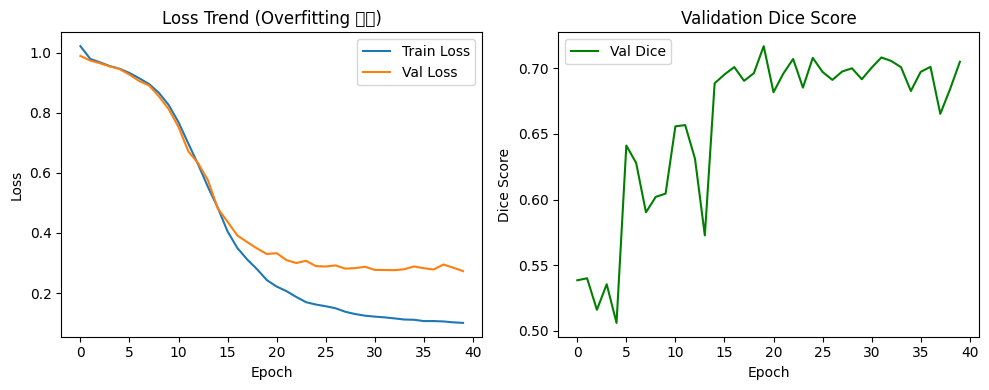


 Best Sensitivity 모델 시각화 결과


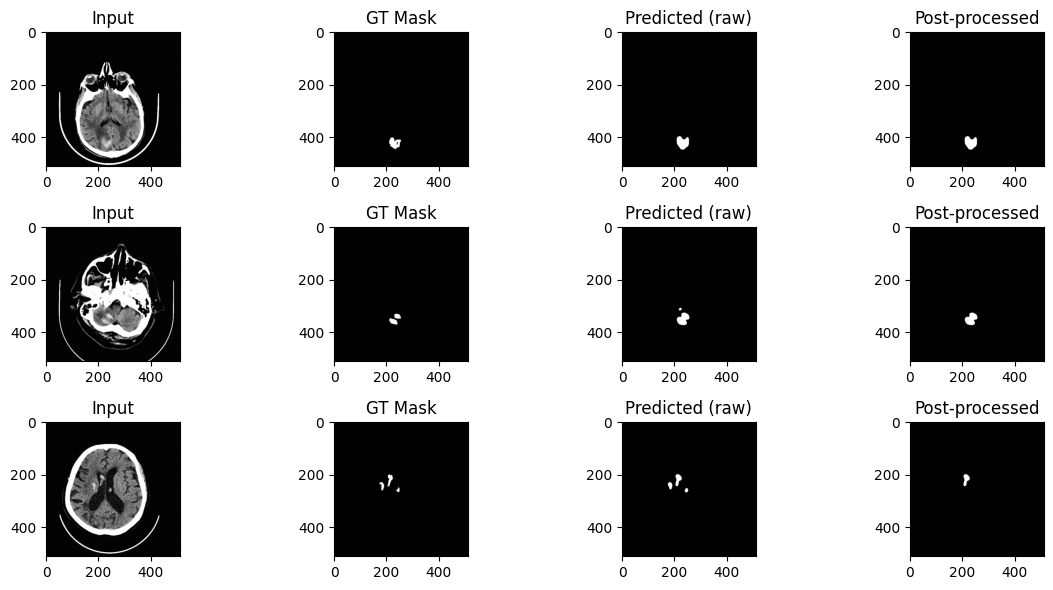

In [15]:
# 제일 위 CONFIG 에서 수동 설정 가능
device = torch.device(CONFIG["device"])

# --- 모델 생성 ---
# 1. 모델 생성
model = build_model().to(device)

# 2. 옵티마이저 및 손실 함수 정의
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])
# criterion = combined_loss  # BCE + Dice: Val Loss = 0.3825 | Dice: 0.6969 | IoU: 0.5727 | Sens: 0.7329 | Spec: 0.9981
criterion = combined_focal_dice

# 3. 학습 루프 실행
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=CONFIG["device"],
    num_epochs=CONFIG["num_epochs"]
)
# 추후 필요하면 config.json 같은 설정 파일로 관리

In [16]:
# --- 테스트 함수 ---
def evaluate_on_testset(model, test_loader, criterion, device):
    """
    저장된 best_model_sens.pth를 로드하여 테스트셋(test_loader)으로 최종 일반화 성능 평가 및 시각화
    """
    import matplotlib.pyplot as plt

    model_path = "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/best_model_sens.pth"
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    test_loss, metrics = validate(model, test_loader, criterion, device)

    print("\n[Best Model 기준] 테스트셋 성능 평가")
    print(f"테스트 손실: {test_loss:.4f}")
    print(f"Dice: {metrics['dice']:.4f} | IoU: {metrics['iou']:.4f} | "
          f"Sens: {metrics['sensitivity']:.4f} | Spec: {metrics['specificity']:.4f} | "
          f"Precision: {metrics['precision']:.4f} | F1: {metrics['f1_score']:.4f}")

    # 테스트셋 시각화
    model.eval()
    sample_images, sample_masks = next(iter(test_loader))
    sample_images = sample_images.to(device)
    with torch.no_grad():
        preds_raw = model(sample_images)
        preds = torch.sigmoid(preds_raw)
        preds_bin = (preds > 0.5).float()

    # 시각화
    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(sample_images[i][0].cpu(), cmap='gray')
        plt.title("Input")

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(sample_masks[i][0].cpu(), cmap='gray')
        plt.title("GT Mask")

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(preds_bin[i][0].cpu(), cmap='gray')
        plt.title("Predicted")
    plt.tight_layout()
    plt.show()


[Best Model 기준] 테스트셋 성능 평가
테스트 손실: 0.9239
Dice: 0.5589 | IoU: 0.4221 | Sens: 0.8652 | Spec: 0.9934 | Precision: 0.4727 | F1: 0.5706


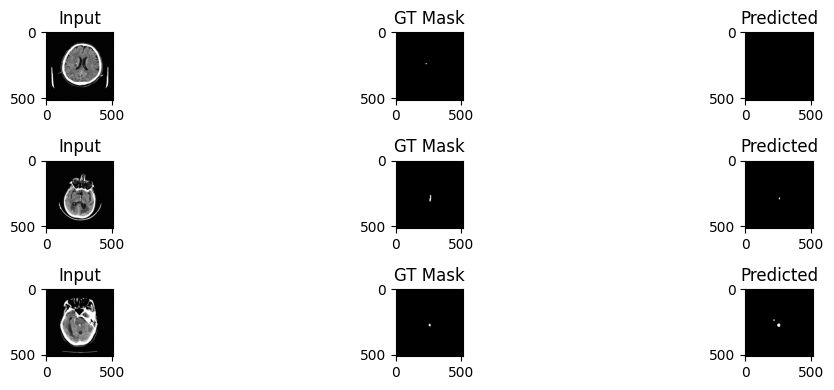

In [17]:
# 4. 최적으로 학습된 모델을 평가용 데이터로 테스트 (test_loader)
device = torch.device(CONFIG["device"])

# 1. 모델 경로 및 불러오기
model_save_path = "/content/drive/MyDrive/Daejeon_Medcoding(2024-12~2025-07)/이미지 프로젝트/best_model_sens.pth"
model = build_model().to(device)  # ← 반드시 모델 구조 먼저 만들고
model.load_state_dict(torch.load(model_save_path))
model.eval()

# 2. 손실 함수 설정
criterion = combined_focal_dice  # or combined_loss

# 3. 테스트셋 평가 실행
evaluate_on_testset(model, test_loader, criterion, device)

전체 모델링 코드 흐름 요약 <br>
1️⃣ 데이터 준비	CT DICOM, 오버레이 PNG 분리 후 → 마스크 추출<br>
2️⃣ 전처리 파이프라인	DICOM / NIfTI → CLAHE, HU 윈도우링, 리사이즈 후 저장<br>
3️⃣ Dataset 구성	DICOM + PNG 마스크를 쌍으로 불러오는 CTDicomDataset 클래스<br>
4️⃣ 모델 구성	ResUNet50 + 업샘플링(UpBlock) + skip 연결<br>
5️⃣ 손실 함수 구성	DiceLoss, FocalLoss, BCE, 복합 손실 함수 (combined_focal_dice)<br>
6️⃣ 학습 루프	train_model() 안에서 train_one_epoch() + validate()<br>
7️⃣ 평가 시각화	마지막 에폭에서 예측 결과 시각화 (input/mask/pred)<br>

자주 발생했던 오류 & 해결 방법 정리<br>
오류/현상	원인	해결 방법 순<br>
⚠ conv_transpose 채널 mismatch	skip 연결 채널 수 계산 오류	UpBlock(in, skip, out)으로 명시<br>
⚠ 마스크 해상도 mismatch	마스크 리사이즈 누락	Image.NEAREST로 마스크도 (512,512) 리사이즈<br>
⚠ sensitivity = 1.0, spec = 0.0	출력이 전부 1 or 0	예측이 잘못됨 → threshold 또는 loss 점검<br>
⚠ validate() unpack 오류	return 하나였는데 두 개 받음	return val_loss, metrics 구조로 수정 완료<br>
⚠ 학습 지표가 의미없음	Focal loss 시 학습 초기값 분산	sigmoid, threshold=0.5 처리 후 안정화<br>
⚠ 학습 config 미적용	lr, epochs 등 코드에 하드코딩	CONFIG['learning_rate'] 등으로 통일시켜 적용<br>


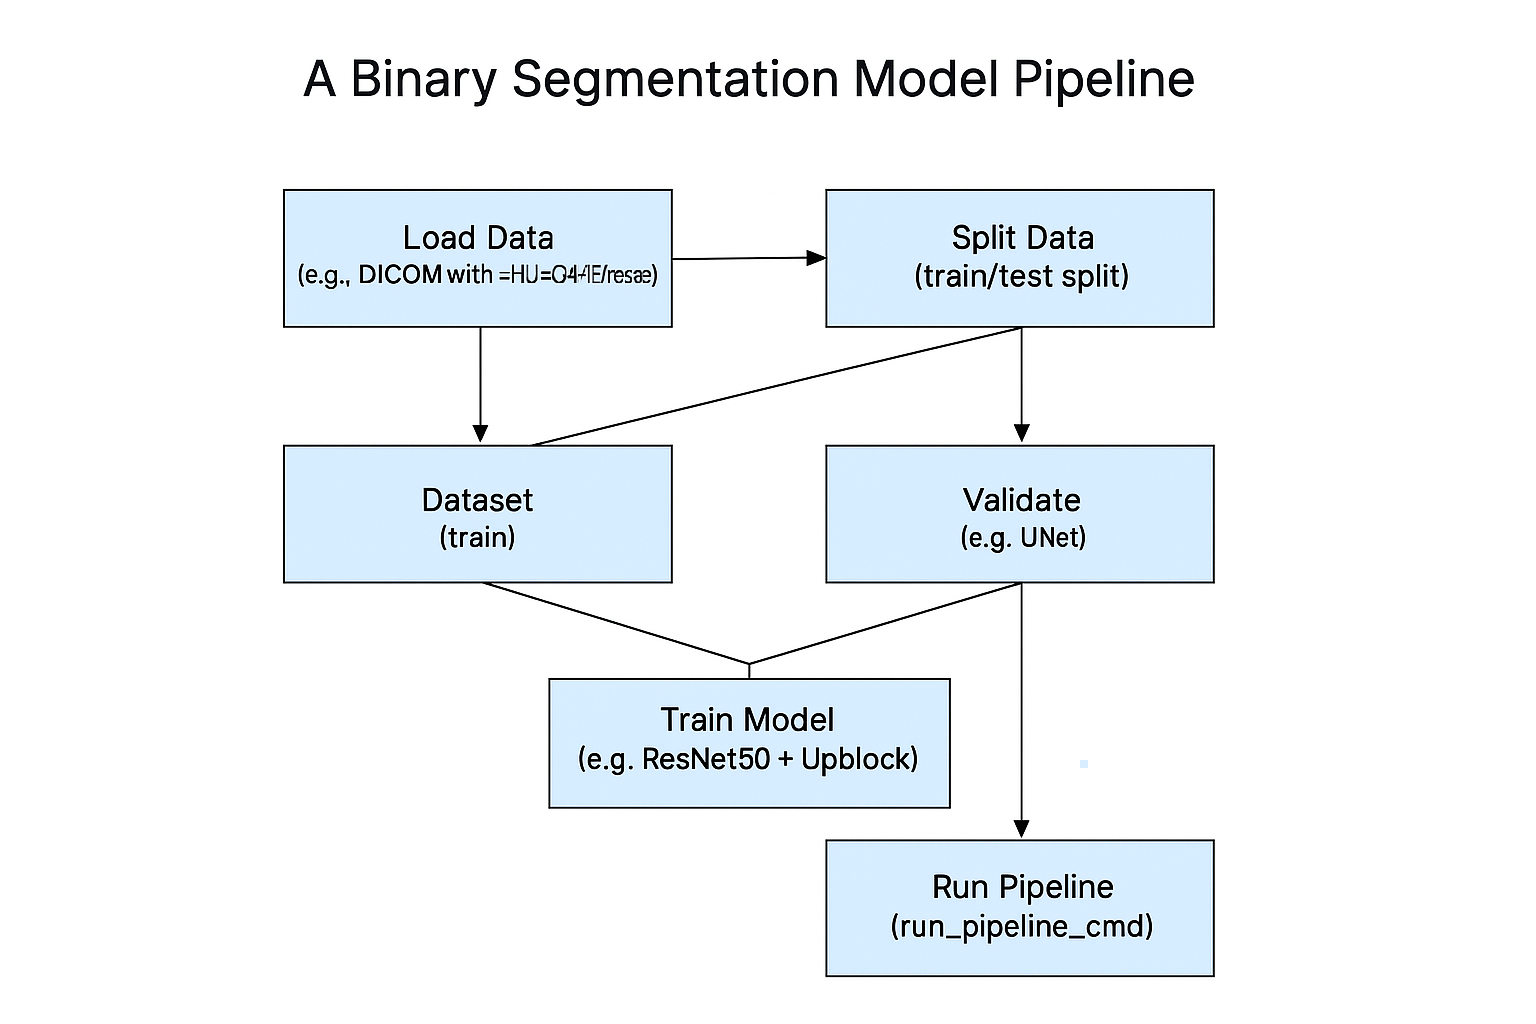